In [1]:
import os
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import utils
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")

# Tiltaksovervakingen: opsjon for kvalitetskontroll av analysedata
## Notebook 3: Outlier detection for whole water samples

Exploring distributions for **single parameters** (as in notebook 2) is a reasonable starting point for quality assurance, but a more general approach is to look for "outliers" at the **water sample** level i.e. samples that are of questionable quality because *one or more* parameter values are unusual. If the suite of water quality parameters analysed is consistent (i.e. no data gaps), then each sample can be considered as a point in $n$ dimensional space, where $n$ is the number of parameters measured. Rather than looking for "outliers" along a single dimension (as in the distribution plots considered already), we can instead look for "outliers" in this higher dimensional space. A variety of algorithms are available to do this, some of which are explored below. 

## 1. Terminology: "outlier" versus "novelty" detection

"**Outlier**" and "**novelty**" detection are two different kinds of **anomaly** detection i.e. where we are interested in detecting abnormal or unusual observations. The difference between the two is important, but often overlooked:

 * **Outlier detection:** We have a **single dataset** that is believed to contain "outliers", which are observations that are "far" from the others (for some chosen definition of "far"). Outlier detection estimators thus try to fit the regions where the data is most concentrated, ignoring the deviant observations.

 * **Novelty detection:** We have access to a **reference dataset** that is *not* polluted by outliers, and we are interested in detecting whether a new observation (from a second dataset) is an outlier - a "novelty" - or not
 
In the context of this project, we are primarily interested in **novelty detection**, because we have a reference historic dataset extracted from Vannmiljø and we would like to gauge whether observations in the "new" dataset are sufficiently unusual/unlikely to warrant further investigation and reanalysis. However, the [summary in the previous notebook](https://nbviewer.jupyter.org/github/NIVANorge/tiltaksovervakingen/blob/master/notebooks/02_distribution_plots.ipynb#3.-Summary) identified some possible issues in the Vannmiljø data, as well as in the "new" data. I am therefore reluctant to use the historic Vannmiljø dataset as a "reference" without additional cleaning. Instead, to begin with, at least, I will combine the "new" and "historic" results into a single dataset and then perform **outlier detection** (not novelty detection). This can be revised later if desired.

## 2. Read data

In [2]:
# Choose dataset to process
lab = "Eurofins"
year = 2025
qtr = 1
version = 1

In [3]:
fold_path = f"../../output/{lab.lower()}_{year}_q{qtr}_v{version}"

In [4]:
# Read from SQLite
stn_df, df = utils.read_data_from_sqlite(lab, year, qtr, version)

# # Subset data to just the quarter of interest
# months_dict = {
#     "q1": [1, 2, 3],
#     "q2": [4, 5, 6],
#     "q3": [7, 8, 9],
#     "q4": [10, 11, 12],
# }
# months = months_dict[qtr]
# df = df[df["sample_date"].dt.month.isin(months)]

df.head()

,vannmiljo_code,sample_date,lab,period,depth1,depth2,ALK_mmol/l,ANC_µekv/l,CA_mg/l,CL_mg/l,...,N-NO3_µg/l N,N-TOT_µg/l N,NA_mg/l,P-TOT_µg/l P,PH_<ubenevnt>,RAL_µg/l Al,SIO2_µg/l Si,SO4_mg/l,TEMP_°C,TOC_mg/l C
0,002-105961,2022-04-04,Eurofins Environment Testing Norway (Moss),historic,0.0,0.0,NaN,190.0,3.6,1.4,...,42.0,270.0,0.77,14.0,6.3,48.0,NaN,0.55,4.0,14.0
1,002-105961,2022-04-11,Eurofins Environment Testing Norway (Moss),historic,0.0,0.0,NaN,NaN,4.1,NaN,...,NaN,NaN,NaN,NaN,6.3,NaN,NaN,NaN,4.0,NaN
2,002-105961,2022-04-18,Eurofins Environment Testing Norway (Moss),historic,0.0,0.0,NaN,NaN,3.6,NaN,...,NaN,NaN,NaN,NaN,6.3,NaN,NaN,NaN,NaN,NaN
3,002-105961,2022-04-25,Eurofins Environment Testing Norway (Moss),historic,0.0,0.0,NaN,NaN,1.6,NaN,...,NaN,NaN,NaN,NaN,5.5,NaN,NaN,NaN,2.0,NaN
4,002-105961,2022-05-02,Eurofins Environment Testing Norway (Moss),historic,0.0,0.0,NaN,72.0,1.4,1.3,...,5.5,240.0,0.52,14.0,5.6,51.0,NaN,0.12,2.0,14.0


## 3. Select parameters

In order to perform outlier detection in a multi-dimensional space, it is necessary that all water samples have a **complete set of values for all parameters**. This is because outlier detection algorithms work by calculating distance metrics between samples, and this is not possible if a sample can't be located along one or more of the dimension axes due to missing values. It is therefore necessary to choose a set of parameters where the data are complete.

The code below calculates the percentage of the time that each lab measures each parameter, where the percentage is calculated as:

    100 * number_of_samples_for_par_X_from_lab_Y / total_number_of_samples_from_lab_Y

In [5]:
# Percentage of total samples analysed per parameter, split by lab
pct_df = df.groupby("lab").agg("count")
tot_samps = pct_df["period"].copy()

for col in pct_df.columns:
    pct_df[col] = 100 * pct_df[col] / tot_samps

pct_df = pct_df.iloc[:, 6:]

pct_df

,ANC_µekv/l,CA_mg/l,CL_mg/l,ILAL_µg/l Al,KOND_mS/m,K_mg/l,LAL_µg/l Al,MG_mg/l,N-NO3_µg/l N,N-TOT_µg/l N,NA_mg/l,P-TOT_µg/l P,PH_<ubenevnt>,RAL_µg/l Al,SIO2_µg/l Si,SO4_mg/l,TEMP_°C,TOC_mg/l C
lab,,,,,,,,,,,,,,,,,,
Eurofins,21.182266,99.753695,21.182266,41.625616,41.625616,21.182266,41.625616,21.182266,21.182266,21.182266,21.182266,21.182266,99.753695,41.625616,21.182266,21.182266,20.935961,41.625616
Eurofins (historic),23.470505,93.052730,23.595681,52.010640,52.010640,25.238617,0.000000,23.282741,23.626975,21.858864,23.173212,21.467689,98.278830,46.330778,0.000000,23.705210,26.537318,52.026287
Eurofins Environment Testing Norway (Moss),23.223485,99.696563,23.230541,50.744478,50.758591,23.237598,0.000000,23.237598,23.145861,21.734528,23.237598,21.805095,99.760073,49.029709,0.000000,23.223485,21.424035,50.765648
NIVA (historic),15.078353,97.593162,15.648197,36.170053,97.555672,15.640699,0.052486,15.663193,15.625703,15.663193,15.663193,15.648197,97.750619,36.170053,11.696783,15.648197,5.226063,15.663193
Rådgivende Biologer AS,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,100.000000,0.000000,100.000000
VestfoldLAB (historic),17.410328,99.872806,17.735945,28.766217,17.730857,17.730857,28.308318,17.730857,2.976342,17.374714,17.730857,16.118036,99.872806,36.677690,14.723989,17.725770,18.224370,22.604935


Text(0.5, 1.0, 'Percentage of total samples analysed per parameter, split by lab')

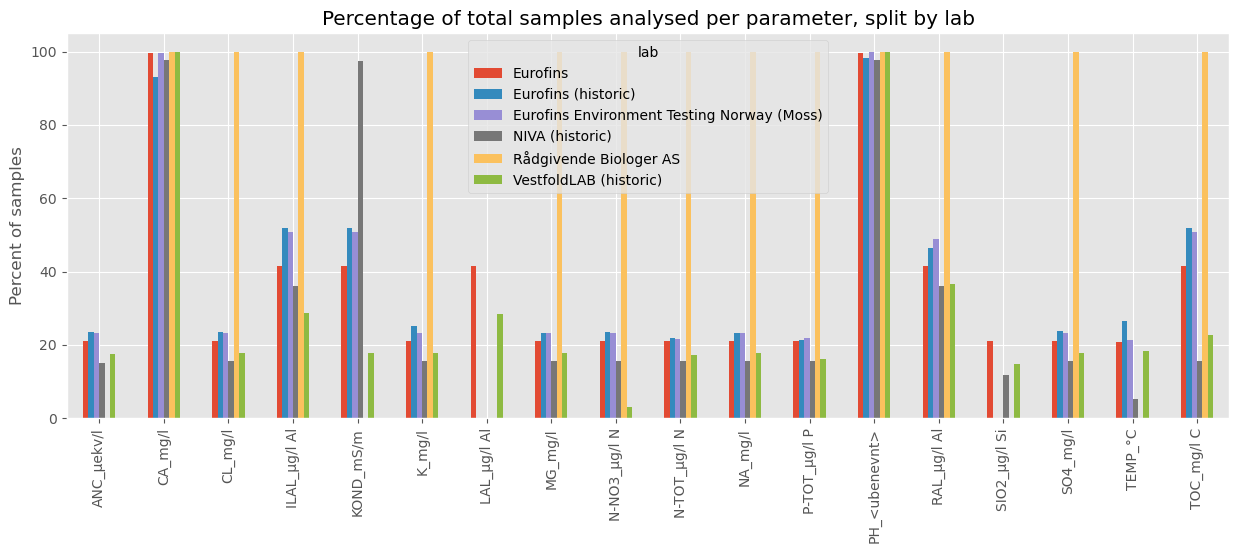

In [6]:
# Plot
ax = pct_df.T.plot.bar(figsize=(15, 5))
ax.set_ylabel("Percent of samples")
ax.set_title("Percentage of total samples analysed per parameter, split by lab")

## 4. Isolation Forests

Isolation Forests are a type of random forest well suited to outlier detection. They have the advantage of making few assumptions about the underlying data distribution, which is useful in situations where - as here - most/all of the variables are strongly skewed.

Isolation forests have a `contamination` parameter, which can be broadly interpreted as the "expected proportion of outliers in the dataset". In other words, setting `contamination=0.01` roughly translates to finding the most unusual 1% of data values. Without a strong theoretical basis for setting the `contamination` parameter, it must be found either by manual tuning or be fixed based on practical considerations (e.g. how many water samples can we realistically afford to reanalyse).

### 4.1. `CA` and `PH` only

The code below applies the isolation forest algorithm to `CA` and `PH`. Since these are almost always measured, this includes virtually all water samples (both new and historic) in the dataset.

In [7]:
# Columns of interest
key_cols = ["vannmiljo_code", "sample_date", "lab", "period", "depth1", "depth2"]
par_cols = ["CA_mg/l", "PH_<ubenevnt>"]

# Run algorithm
data = df[key_cols + par_cols].dropna()
data = utils.isolation_forest(data, par_cols, contamination=0.01)

# Summarise results
all_out = data.query("pred == 'outlier'")
his_out = data.query("(pred == 'outlier') and (period == 'historic')")
new_out = data.query("(pred == 'outlier') and (period == 'new')")

csv_path = os.path.join(fold_path, "isoforest_ca_ph.csv")
new_out.to_csv(csv_path, index=False)

print(f"The total number of samples in the dataset is: {len(data)}.\n")
print(
    f"The total number of outliers detected is {len(all_out)}:\n"
    f"    {len(his_out)} in the 'historic' period\n"
    f"    {len(new_out)} in the 'new' period\n"
)

new_out

The total number of samples in the dataset is: 53868.

The total number of outliers detected is 539:
    527 in the 'historic' period
    12 in the 'new' period



,vannmiljo_code,sample_date,lab,period,depth1,depth2,CA_mg/l,PH_<ubenevnt>,pred
5962,021-28450,2025-03-17,Eurofins,new,0.0,0.0,5.7,6.7,outlier
5963,021-28450,2025-03-23,Eurofins,new,0.0,0.0,7.5,6.9,outlier
10879,022-58904,2025-03-03,Eurofins,new,0.0,0.0,5.7,7.0,outlier
24989,030-58768,2025-02-17,Eurofins,new,0.0,0.0,4.1,7.2,outlier
25456,030-58835,2025-02-17,Eurofins,new,0.0,0.0,50.0,6.5,outlier
26836,030-58838,2025-01-06,Eurofins,new,0.0,0.0,22.0,6.8,outlier
26837,030-58838,2025-01-13,Eurofins,new,0.0,0.0,11.0,6.2,outlier
26841,030-58838,2025-02-16,Eurofins,new,0.0,0.0,11.0,6.4,outlier
35207,038-58853,2025-01-27,Eurofins,new,0.0,0.0,3.0,4.9,outlier
36552,038-88032,2025-01-27,Eurofins,new,0.0,0.0,3.5,5.1,outlier


This initial approach identifies the **strangest 1% of the dataset overall**. 

 * Most of the unusual values (300 out of 326) are actually in the historic dataset (i.e. they are already in Vannmiljø). 
 
 * The 26 samples in the 'new' dataset that have been classified as outliers are predominantly those with unusually high concentrations of `CA` (greater than around 5 mg/l; see plots below).

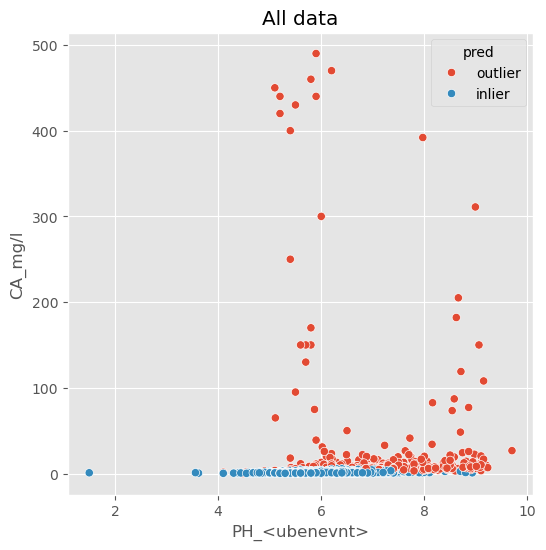

In [8]:
# Plot all samples
fig, ax = plt.subplots(figsize=(6, 6))
sn.scatterplot(
    data=data,
    x="PH_<ubenevnt>",
    y="CA_mg/l",
    hue="pred",
    ax=ax,
    hue_order=["outlier", "inlier"],
)
_ = ax.set_title("All data")

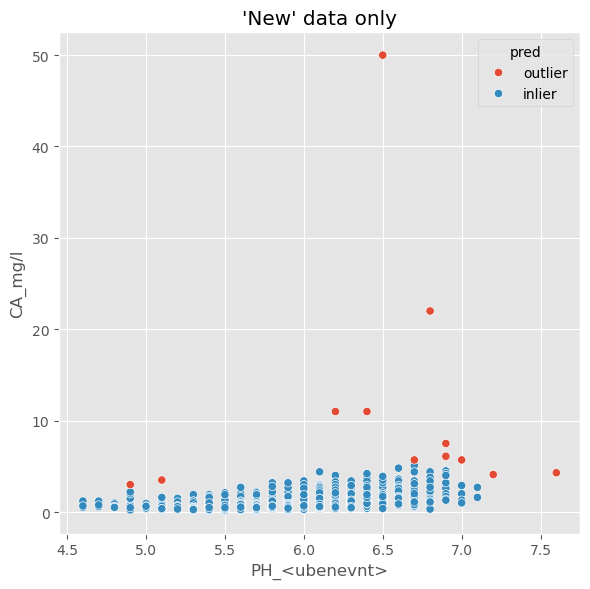

In [9]:
# Plot just the 'new' samples
data_new = data.query("period == 'new'")
fig, ax = plt.subplots(figsize=(6, 6))
sn.scatterplot(
    data=data_new,
    x="PH_<ubenevnt>",
    y="CA_mg/l",
    hue="pred",
    ax=ax,
    hue_order=["outlier", "inlier"],
)
_ = ax.set_title("'New' data only")
plt.tight_layout()
png_path = os.path.join(fold_path, "isoforest_ca_ph_plot.png")
plt.savefig(png_path, dpi=200)

### 4.2. `CA`, `PH`, `ILAL` and `RAL`

In [10]:
# Columns of interest
key_cols = ["vannmiljo_code", "sample_date", "lab", "period", "depth1", "depth2"]
par_cols = ["CA_mg/l", "PH_<ubenevnt>", "ILAL_µg/l Al", "RAL_µg/l Al"]

# Run algorithm
data = df[key_cols + par_cols].dropna()
data = utils.isolation_forest(data, par_cols, contamination=0.01)

# Summarise results
all_out = data.query("pred == 'outlier'")
his_out = data.query("(pred == 'outlier') and (period == 'historic')")
new_out = data.query("(pred == 'outlier') and (period == 'new')")

print(f"The total number of samples in the dataset is: {len(data)}.\n")
print(
    f"The total number of outliers detected is {len(all_out)}:\n"
    f"    {len(his_out)} in the 'historic' period\n"
    f"    {len(new_out)} in the 'new' period\n"
)

new_out

The total number of samples in the dataset is: 20257.

The total number of outliers detected is 203:
    200 in the 'historic' period
    3 in the 'new' period



,vannmiljo_code,sample_date,lab,period,depth1,depth2,CA_mg/l,PH_<ubenevnt>,ILAL_µg/l Al,RAL_µg/l Al,pred
12646,023-58889,2025-02-05,Eurofins,new,0.0,0.0,1.5,4.9,66.0,210.0,outlier
14430,025-45779,2025-01-27,Eurofins,new,0.0,0.0,1.2,4.6,86.0,160.0,outlier
26836,030-58838,2025-01-06,Eurofins,new,0.0,0.0,22.0,6.8,13.0,17.0,outlier


### 4.3. All parameters *except* `LAL` and `TEMP`

In [11]:
# Columns of interest
key_cols = ["vannmiljo_code", "sample_date", "lab", "period", "depth1", "depth2"]
excl_cols = ["TEMP_°C", "LAL_µg/l Al"]
par_cols = [col for col in df.columns if col not in (key_cols + excl_cols)]

# Run algorithm
data = df[key_cols + par_cols].dropna()
data = utils.isolation_forest(data, par_cols, contamination=0.01)

# Summarise results
all_out = data.query("pred == 'outlier'")
his_out = data.query("(pred == 'outlier') and (period == 'historic')")
new_out = data.query("(pred == 'outlier') and (period == 'new')")

print(f"The total number of samples in the dataset is: {len(data)}.\n")
print(
    f"The total number of outliers detected is {len(all_out)}:\n"
    f"    {len(his_out)} in the 'historic' period\n"
    f"    {len(new_out)} in the 'new' period\n"
)

new_out

The total number of samples in the dataset is: 1677.

The total number of outliers detected is 17:
    8 in the 'historic' period
    9 in the 'new' period



,vannmiljo_code,sample_date,lab,period,depth1,depth2,ALK_mmol/l,ANC_µekv/l,CA_mg/l,CL_mg/l,...,N-NO3_µg/l N,N-TOT_µg/l N,NA_mg/l,P-TOT_µg/l P,PH_<ubenevnt>,RAL_µg/l Al,SIO2_µg/l Si,SO4_mg/l,TOC_mg/l C,pred
14430,025-45779,2025-01-27,Eurofins,new,0.0,0.0,0.03,-44.0,1.2,19.0,...,68.0,140.0,8.6,2.9,4.6,160.0,748.069241,2.48,3.6,outlier
18517,027-58829,2025-01-27,Eurofins,new,0.0,0.0,0.43,-31.0,3.2,35.0,...,110.0,150.0,15.0,2.0,5.8,23.0,654.560586,4.03,1.0,outlier
22367,027-79278,2025-01-05,Eurofins,new,0.0,0.0,0.12,160.0,3.2,12.0,...,560.0,820.0,7.3,18.0,6.9,12.0,2384.470706,3.24,2.2,outlier
22368,027-79278,2025-01-27,Eurofins,new,0.0,0.0,0.14,200.0,3.8,16.0,...,800.0,910.0,10.0,21.0,6.8,15.0,2290.962051,3.27,2.4,outlier
22369,027-79278,2025-02-24,Eurofins,new,0.0,0.0,0.08,83.0,2.9,16.0,...,630.0,1100.0,8.1,81.0,6.4,28.0,1496.138482,2.66,3.0,outlier
22370,027-79278,2025-03-03,Eurofins,new,0.0,0.0,0.14,190.0,4.0,16.0,...,600.0,980.0,9.2,16.0,6.9,12.0,2290.962051,3.35,2.0,outlier
26836,030-58838,2025-01-06,Eurofins,new,0.0,0.0,0.12,5700.0,22.0,730.0,...,160.0,230.0,510.0,2.1,6.8,17.0,701.314913,117.00,1.2,outlier
28841,032-58839,2025-02-04,Eurofins,new,0.0,0.0,0.10,150.0,4.0,12.0,...,680.0,950.0,7.3,2.0,6.2,27.0,1683.155792,3.05,1.9,outlier
35381,038-58854,2025-01-27,Eurofins,new,0.0,0.0,0.03,1.5,2.8,22.0,...,320.0,350.0,9.1,3.7,5.8,23.0,561.051931,2.92,1.3,outlier
